# Example Codes for Using the SCMS Algorithms in ``SCONCE-SCMS``

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from mpl_toolkits.basemap import Basemap

from sconce.utils import cart2sph, sph2cart, CirSphSampling
from sconce.EucSCMS import KDE, SCMSLog
from sconce.DirSCMS import DirKDE, DirSCMSLog
from sconce.DirLinSCMS import DirLinSCMSLog

import ray
from sconce.EucSCMS_RayFunc import SCMSLog_Ray
from sconce.DirSCMS_RayFunc import DirSCMSLog_Ray
from sconce.DirLinSCMS_RayFunc import DirLinSCMSLog_Ray

## Example 1: A circle crossing the North and South poles on the unit sphere $\mathbb{S}^2$

In [2]:
np.random.seed(123)  # Set an arbitrary seed for reproducibility
# Sampling the points on a circle that crosses through the north and south poles
cir_samp = CirSphSampling(2000, lat_c=0, lon_range=[-180,180], sigma=0.1, pv_ax=np.array([1,0,0]))

true_cur = CirSphSampling(2000, lat_c=0, lon_range=[-180,180], sigma=0, pv_ax=np.array([1,0,0]))

lon_c, lat_c, r = cart2sph(*cir_samp.T)
cir_samp_ang = np.concatenate((lon_c.reshape(len(lon_c),1), 
                               lat_c.reshape(len(lat_c),1)), axis=1)

d_hat_dat = DirKDE(cir_samp, cir_samp, h=None)

The current bandwidth is 0.7592252306206649.



### Application of the standard SCMS algorithm to the 2D angular coordinates

In [3]:
SCMS_Eu_log = SCMSLog(cir_samp_ang, data=cir_samp_ang, d=1, h=None, eps=1e-7, max_iter=5000)
Eu_ridge_log = SCMS_Eu_log[:,:,SCMS_Eu_log.shape[2]-1]

The current bandwidth is 20.062747464932812.

The SCMS algorithm converges in 166steps!


#### Parallel implementation of the standard SCMS algorithm

In [4]:
# SCMS
ray.init()
mesh_0 = cir_samp_ang
dataset = cir_samp_ang
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=20.0627, 
                                         eps=1e-7, max_iter=5000))
EuSCMS_pts = ray.get(result_ids)
EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
ray.shutdown()

2022-07-13 06:32:49,848	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


The outputs from the standard and parallel implementations of the standard SCMS algorithm in ``sconce-scms`` are consistent under some precision levels.

In [5]:
print(all(LA.norm(Eu_ridge_log - EuSCMS_pts, axis=1) < 1e-3))

True


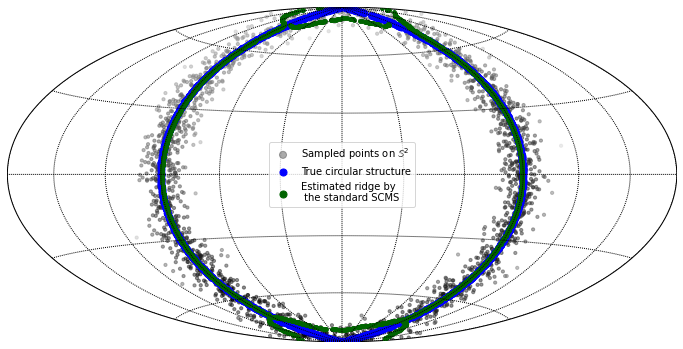

In [6]:
plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(12,10))
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_r_Eu = Eu_ridge_log[:,0]
lat_r_Eu = Eu_ridge_log[:,1]
# Set up map projection
m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
             llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_Eu, y_Eu = m1(lon_r_Eu, lat_r_Eu)
# Scatter plots over the map.
cs = m1.scatter(x_p, y_p, c=1/(d_hat_dat)**(1/20), s=10, cmap='gray', alpha=0.5, 
                label='Sampled points on $\mathbb{S}^2$')
cs = m1.scatter(x_t, y_t, color='blue', s=40, alpha=1, label='True circular structure')
cs = m1.scatter(x_Eu, y_Eu, color='darkgreen', s=15, alpha=1, 
                label='Estimated ridge by \n the standard SCMS')
lgnd = plt.legend(loc='center', numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.show()

### Application of our directional SCMS (DirSCMS) algorithm to the 3D Cartesian coordinates

In [7]:
SCMS_Dir_log = DirSCMSLog(cir_samp, data=cir_samp, d=1, h=None, eps=1e-7, max_iter=5000)
Dir_ridge_log = SCMS_Dir_log[:,:,SCMS_Dir_log.shape[2]-1]

The current bandwidth is 0.7592252306206649.

The directional SCMS algorithm converges in 6steps!


In [8]:
ray.init()
mesh_0 = cir_samp
dataset = cir_samp
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=0.75923, 
                                            eps=1e-7, max_iter=5000))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

2022-07-13 06:33:11,683	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


The outputs from the standard and parallel implementations of our DirSCMS algorithm in ``sconce-scms`` are consistent under some precision levels.

In [9]:
print(all(LA.norm(Dir_ridge_log - DirSCMS_pts, axis=1) < 1e-7))

True


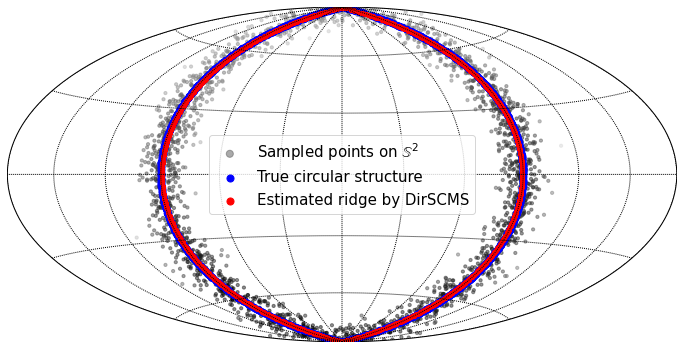

In [10]:
plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(12,10))
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_r_Dir, lat_r_Dir, r = cart2sph(*Dir_ridge_log.T)
# Set up map projection
m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
             llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_Dir, y_Dir = m1(lon_r_Dir, lat_r_Dir)
# Scatter plots over the map.
cs = m1.scatter(x_p, y_p, c=1/(d_hat_dat)**(1/20), s=10, cmap='gray', alpha=0.5, 
                label='Sampled points on $\mathbb{S}^2$')
cs = m1.scatter(x_t, y_t, color='blue', s=40, alpha=1, label='True circular structure')
cs = m1.scatter(x_Dir, y_Dir, color='red', s=15, alpha=1, 
                label='Estimated ridge by DirSCMS')
lgnd = plt.legend(loc='center', numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.show()

## Example 2: 3D Spiral Curve

In [11]:
N = 1000
open_ang = np.pi/3
sigma = 0.2   ## Variance of the additive Gaussian noises
np.random.seed(123)  ## Set an arbitrary seed for reproducibility
t = np.random.rand(N, 1)*4
# Simulated points on the spiral curve data with angular-linear coordinates
cur_dat_ang = np.concatenate([5*t, np.ones((N, 1))*(np.pi/2-open_ang), t], axis=1)
# Convert the first two radian coordinates to their degree measures
cur_dat_ang[:,:2] = (cur_dat_ang[:,:2] % (2*np.pi))/np.pi * 180
# Add some Gaussian noises
cur_dat_ang[:,:2] = (cur_dat_ang[:,:2] + sigma*np.random.randn(N, 2)) % 360
cur_dat_ang[:,2] = cur_dat_ang[:,2] + sigma*np.random.randn(N)

# Convert the angular-linear coordinates of simulated data to their directional-linear coordinates
X, Y, Z = sph2cart(*cur_dat_ang[:,:2].T)
cur_dat = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1), 
                          cur_dat_ang[:,2].reshape(-1,1)], axis=1)

# Convert the angular-linear coordinates of simulated data to their Cartesian coordinates
phi_pert = (cur_dat_ang[:,1]/180) * np.pi
th_pert = (cur_dat_ang[:,0]/180) * np.pi
R_pert = cur_dat_ang[:,2]
Z_sim = R_pert * np.sin(phi_pert)
X_sim = R_pert * np.cos(phi_pert) * np.cos(th_pert)
Y_sim = R_pert * np.cos(phi_pert) * np.sin(th_pert)
cur_dat_3D = np.concatenate([X_sim.reshape(-1,1), Y_sim.reshape(-1,1), 
                             Z_sim.reshape(-1,1)], axis=1)

### Standard SCMS algorithm on the spiral curve data under their 3D Cartesian coordinates

In [12]:
ray.init()
mesh_0 = cur_dat_3D
dataset = cur_dat_3D
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=None, eps=1e-7, 
                                         max_iter=5000))
EuSCMS_pts1 = ray.get(result_ids)
EuSCMS_pts1 = np.concatenate(EuSCMS_pts1, axis=0)
ray.shutdown()

2022-07-13 06:33:19,589	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=136434) The current bandwidth is 0.40787949202414375.
(pid=136434) 
(pid=136435) The current bandwidth is 0.40787949202414375.
(pid=136435) 
(pid=136428) The current bandwidth is 0.40787949202414375.
(pid=136428) 
(pid=136430) The current bandwidth is 0.40787949202414375.
(pid=136430) 
(pid=136431) The current bandwidth is 0.40787949202414375.
(pid=136431) 
(pid=136432) The current bandwidth is 0.40787949202414375.
(pid=136432) 
(pid=136433) The current bandwidth is 0.40787949202414375.
(pid=136433) 
(pid=136429) The current bandwidth is 0.40787949202414375.
(pid=136429) 
(pid=136430) The current bandwidth is 0.40787949202414375.
(pid=136430) 
(pid=136432) The current bandwidth is 0.40787949202414375.
(pid=136432) 
(pid=136433) The current bandwidth is 0.40787949202414375.
(pid=136433) 
(pid=136435) The current bandwidth is 0.40787949202414375.
(pid=136435) 
(pid=136432) The current bandwidth is 0.40787949202414375.
(pid=136432) 
(pid=136429) The current bandwidth is 0.40787949202

(pid=136430) The current bandwidth is 0.40787949202414375.
(pid=136430) 
(pid=136431) The current bandwidth is 0.40787949202414375.
(pid=136431) 
(pid=136428) The current bandwidth is 0.40787949202414375.
(pid=136428) 
(pid=136432) The current bandwidth is 0.40787949202414375.
(pid=136432) 
(pid=136435) The current bandwidth is 0.40787949202414375.
(pid=136435) 
(pid=136428) The current bandwidth is 0.40787949202414375.
(pid=136428) 
(pid=136433) The current bandwidth is 0.40787949202414375.
(pid=136433) 
(pid=136434) The current bandwidth is 0.40787949202414375.
(pid=136434) 
(pid=136429) The current bandwidth is 0.40787949202414375.
(pid=136429) 
(pid=136431) The current bandwidth is 0.40787949202414375.
(pid=136431) 
(pid=136430) The current bandwidth is 0.40787949202414375.
(pid=136430) 
(pid=136432) The current bandwidth is 0.40787949202414375.
(pid=136432) 
(pid=136429) The current bandwidth is 0.40787949202414375.
(pid=136429) 
(pid=136431) The current bandwidth is 0.40787949202

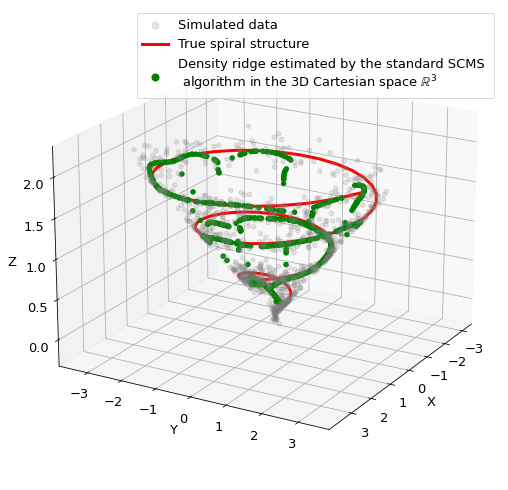

In [13]:
Z_true = np.linspace(0, 4, 101)
X = Z_true*np.sin(open_ang)*np.cos(Z_true*5)
Y = Z_true*np.sin(open_ang)*np.sin(Z_true*5)
Z = Z_true*np.cos(open_ang)

plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 30)
ax.scatter(cur_dat_3D[:,0], cur_dat_3D[:,1], cur_dat_3D[:,2], 
               color='grey', alpha=0.2, label='Simulated data')
ax.plot3D(X, Y, Z, 'red', linewidth=3, label='True spiral structure')
ax.scatter(EuSCMS_pts1[:,0], EuSCMS_pts1[:,1], EuSCMS_pts1[:,2], 
           color='green', alpha=1, s=20, 
           label='Density ridge estimated by the standard SCMS \n algorithm in the 3D Cartesian space $\mathbb{R}^3$')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
fig.tight_layout()
plt.show()

### Standard SCMS algorithm on the spiral curve data under their 3D angular-linear coordinates, i.e., (longitudes, latitudes, linear covariates)

In [14]:
ray.init()
mesh_0 = cur_dat_ang
dataset = cur_dat_ang
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=None, eps=1e-7, 
                                         max_iter=5000))
EuSCMS_pts2 = ray.get(result_ids)
EuSCMS_pts2 = np.concatenate(EuSCMS_pts2, axis=0)
ray.shutdown()

2022-07-13 06:33:48,593	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=136860) The current bandwidth is 13.206074579176766.
(pid=136860) 
(pid=136862) The current bandwidth is 13.206074579176766.
(pid=136862) 
(pid=136859) The current bandwidth is 13.206074579176766.
(pid=136859) 
(pid=136861) The current bandwidth is 13.206074579176766.
(pid=136861) 
(pid=136863) The current bandwidth is 13.206074579176766.
(pid=136863) 
(pid=136858) The current bandwidth is 13.206074579176766.
(pid=136858) 
(pid=136864) The current bandwidth is 13.206074579176766.
(pid=136864) 
(pid=136865) The current bandwidth is 13.206074579176766.
(pid=136865) 
(pid=136860) The current bandwidth is 13.206074579176766.
(pid=136860) 
(pid=136861) The current bandwidth is 13.206074579176766.
(pid=136861) 
(pid=136863) The current bandwidth is 13.206074579176766.
(pid=136863) 
(pid=136858) The current bandwidth is 13.206074579176766.
(pid=136858) 
(pid=136864) The current bandwidth is 13.206074579176766.
(pid=136864) 
(pid=136865) The current bandwidth is 13.206074579176766.
(pid=1

(pid=136860) The current bandwidth is 13.206074579176766.
(pid=136860) 
(pid=136862) The current bandwidth is 13.206074579176766.
(pid=136862) 
(pid=136859) The current bandwidth is 13.206074579176766.
(pid=136859) 
(pid=136863) The current bandwidth is 13.206074579176766.
(pid=136863) 
(pid=136858) The current bandwidth is 13.206074579176766.
(pid=136858) 
(pid=136864) The current bandwidth is 13.206074579176766.
(pid=136864) 
(pid=136861) The current bandwidth is 13.206074579176766.
(pid=136861) 
(pid=136860) The current bandwidth is 13.206074579176766.
(pid=136860) 
(pid=136862) The current bandwidth is 13.206074579176766.
(pid=136862) 
(pid=136864) The current bandwidth is 13.206074579176766.
(pid=136864) 
(pid=136865) The current bandwidth is 13.206074579176766.
(pid=136865) 
(pid=136860) The current bandwidth is 13.206074579176766.
(pid=136860) 
(pid=136861) The current bandwidth is 13.206074579176766.
(pid=136861) 
(pid=136863) The current bandwidth is 13.206074579176766.
(pid=1

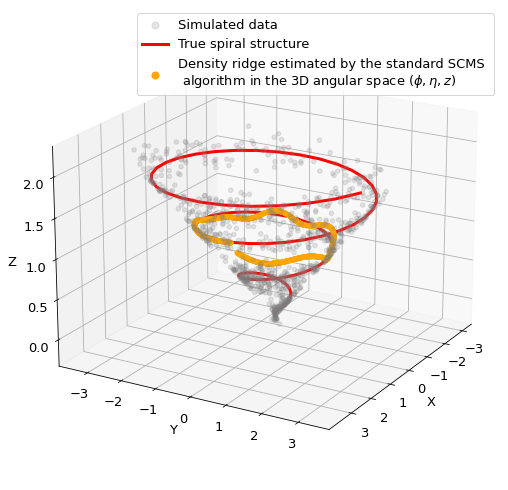

In [15]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 30)
Phi = (EuSCMS_pts2[:,0]/180)*np.pi
Eta = (EuSCMS_pts2[:,1]/180)*np.pi
Eu_Ridges2 = np.concatenate([(EuSCMS_pts2[:,2]*np.cos(Phi)*np.cos(Eta)).reshape(-1,1), 
                             (EuSCMS_pts2[:,2]*np.sin(Phi)*np.cos(Eta)).reshape(-1,1),
                             (EuSCMS_pts2[:,2]*np.sin(Eta)).reshape(-1,1)], axis=1)
ax.scatter(cur_dat_3D[:,0], cur_dat_3D[:,1], cur_dat_3D[:,2], 
               color='grey', alpha=0.2, label='Simulated data')
ax.plot3D(X, Y, Z, 'red', linewidth=3, label='True spiral structure')
ax.scatter(Eu_Ridges2[:,0], Eu_Ridges2[:,1], Eu_Ridges2[:,2], 
           color='orange', alpha=1, s=20, 
           label='Density ridge estimated by the standard SCMS \n algorithm in the 3D angular space $(\phi, \eta, z)$')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
fig.tight_layout()
plt.show()

### Our proposed DirLin SCMS algorithm on the spiral curve data under their directional-linear coordinates in $\Omega_2 \times \mathbb{R}$

In [16]:
DirLinSCMS_path, conv_sign = DirLinSCMSLog(cur_dat, cur_dat, d=1, h=None, b=None, 
                                           q=2, D=1, eps=1e-7, max_iter=5000)
print(all(conv_sign == 1))
DirLin_ridge_log = DirLinSCMS_path[:,:,DirLinSCMS_path.shape[2]-1]

The current bandwidth for directional component is 0.23793125244633434.

The current bandwidth for linear component is 0.30727165601906375.

The directional-linear SCMS algorithm converges in 156 steps!
True


In [17]:
ray.init()
mesh_0 = cur_dat
dataset = cur_dat
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirLinSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=None, b=None, 
                                               q=2, D=1, eps=1e-7, max_iter=5000))
DLSCMS_pts = ray.get(result_ids)
DLSCMS_pts = np.concatenate(DLSCMS_pts, axis=0)
ray.shutdown()

2022-07-13 06:34:11,457	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=137231) The current bandwidth for directional component is 0.23793125244633434.
(pid=137231) 
(pid=137231) The current bandwidth for linear component is 0.30727165601906375.
(pid=137231) 
(pid=137232) The current bandwidth for directional component is 0.23793125244633434.
(pid=137232) 
(pid=137232) The current bandwidth for linear component is 0.30727165601906375.
(pid=137232) 
(pid=137234) The current bandwidth for directional component is 0.23793125244633434.
(pid=137234) 
(pid=137234) The current bandwidth for linear component is 0.30727165601906375.
(pid=137234) 
(pid=137229) The current bandwidth for directional component is 0.23793125244633434.
(pid=137229) 
(pid=137229) The current bandwidth for linear component is 0.30727165601906375.
(pid=137229) 
(pid=137228) The current bandwidth for directional component is 0.23793125244633434.
(pid=137228) 
(pid=137228) The current bandwidth for linear component is 0.30727165601906375.
(pid=137228) 
(pid=137230) The current bandwidth 

(pid=137232) The current bandwidth for directional component is 0.23793125244633434.
(pid=137232) 
(pid=137232) The current bandwidth for linear component is 0.30727165601906375.
(pid=137232) 
(pid=137234) The current bandwidth for directional component is 0.23793125244633434.
(pid=137234) 
(pid=137234) The current bandwidth for linear component is 0.30727165601906375.
(pid=137234) 
(pid=137229) The current bandwidth for directional component is 0.23793125244633434.
(pid=137229) 
(pid=137229) The current bandwidth for linear component is 0.30727165601906375.
(pid=137229) 
(pid=137227) The current bandwidth for directional component is 0.23793125244633434.
(pid=137227) 
(pid=137227) The current bandwidth for linear component is 0.30727165601906375.
(pid=137227) 
(pid=137228) The current bandwidth for directional component is 0.23793125244633434.
(pid=137228) 
(pid=137228) The current bandwidth for linear component is 0.30727165601906375.
(pid=137228) 
(pid=137230) The current bandwidth 

(pid=137232) The current bandwidth for directional component is 0.23793125244633434.
(pid=137232) 
(pid=137232) The current bandwidth for linear component is 0.30727165601906375.
(pid=137232) 
(pid=137228) The current bandwidth for directional component is 0.23793125244633434.
(pid=137228) 
(pid=137228) The current bandwidth for linear component is 0.30727165601906375.
(pid=137228) 
(pid=137231) The current bandwidth for directional component is 0.23793125244633434.
(pid=137231) 
(pid=137231) The current bandwidth for linear component is 0.30727165601906375.
(pid=137231) 
(pid=137230) The current bandwidth for directional component is 0.23793125244633434.
(pid=137230) 
(pid=137230) The current bandwidth for linear component is 0.30727165601906375.
(pid=137230) 
(pid=137234) The current bandwidth for directional component is 0.23793125244633434.
(pid=137234) 
(pid=137234) The current bandwidth for linear component is 0.30727165601906375.
(pid=137234) 
(pid=137229) The current bandwidth 

The outputs from the standard and parallel implementations of our DirLinSCMS algorithm in ``sconce-scms`` are consistent under some precision levels.

In [18]:
print(all(LA.norm(DirLin_ridge_log - DLSCMS_pts, axis=1) < 1e-7))

True


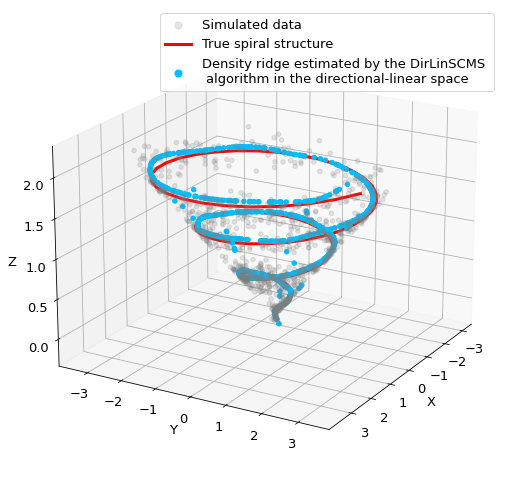

In [19]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 30)
lon, lat, R = cart2sph(*DLSCMS_pts[:,:3].T)
Phi = (lon/180)*np.pi
Eta = (lat/180)*np.pi
DL_Ridges = np.concatenate([(DLSCMS_pts[:,3]*np.cos(Phi)*np.cos(Eta)).reshape(-1,1), 
                            (DLSCMS_pts[:,3]*np.sin(Phi)*np.cos(Eta)).reshape(-1,1),
                            (DLSCMS_pts[:,3]*np.sin(Eta)).reshape(-1,1)], axis=1)
ax.scatter(cur_dat_3D[:,0], cur_dat_3D[:,1], cur_dat_3D[:,2], 
               color='grey', alpha=0.2, label='Simulated data')
ax.plot3D(X, Y, Z, 'red', linewidth=3, label='True spiral structure')
ax.scatter(DL_Ridges[:,0], DL_Ridges[:,1], DL_Ridges[:,2], 
           color='deepskyblue', alpha=1, s=20, 
           label='Density ridge estimated by the DirLinSCMS \n algorithm in the directional-linear space')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
fig.tight_layout()